# Import Libraries

In [32]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint,RocAucCallback
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

# Configurations

In [33]:
# Setup the paths to train and test images
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMG_SIZE = 256

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Data Loading

In [34]:
df = pd.read_csv('./df_augment.csv')[:10]
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338915 entries, 0 to 338914
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  338915 non-null  object 
 1   x         338915 non-null  float64
 2   y         338915 non-null  float64
 3   w         338915 non-null  float64
 4   h         338915 non-null  float64
 5   source    338915 non-null  object 
dtypes: float64(4), object(2)
memory usage: 15.5+ MB


In [35]:
def load_image_and_bbox(image_id, bbox):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    bbox = bbox / (original_size[0] / IMG_SIZE)
    return image, bbox

def parse_dataframe(df, TRAIN_DIR=TRAIN_DIR, AUG_SAVE_DIR=AUG_SAVE_DIR):
    image_ids = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Parsing dataframe and image path'):
        image_id = row['image_id']
        ori_image_path = f'{TRAIN_DIR}/{image_id}.jpg'
        augmented_image_path = f'{AUG_SAVE_DIR}/{image_id}.jpg'
        if os.path.exists(ori_image_path):
            image_path = ori_image_path
        else:
            image_path = augmented_image_path
        image_ids.append(image_path)
    bboxes = df[['x', 'y', 'w', 'h']].values
    return image_ids, bboxes

def create_dataset(image_paths, bboxes, batch_size=32):
    # Create the TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes))
    dataset = dataset.map(lambda x, y: load_image_and_bbox(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

image_ids, bboxes = parse_dataframe(df)


Parsing dataframe and image path: 100%|██████████| 338915/338915 [00:15<00:00, 21848.75it/s]


In [36]:
# Split the dataset
train_paths, test_paths, train_bboxes, test_bboxes = train_test_split(image_ids, bboxes, test_size=0.4, random_state=42)
test_paths, val_paths, test_bboxes, val_bboxes = train_test_split(test_paths, test_bboxes, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = create_dataset(train_paths, train_bboxes)
val_dataset = create_dataset(val_paths, val_bboxes)
test_dataset = create_dataset(test_paths, test_bboxes)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))


In [37]:
for images, bboxes in train_dataset.take(1):
    print(images.shape, bboxes.shape, len(train_dataset))
for images, bboxes in test_dataset.take(1):
    print(images.shape, bboxes.shape, len(test_dataset))
for images, bboxes in val_dataset.take(1):
    print(images.shape, bboxes.shape, len(val_dataset))

(32, 256, 256, 3) (32, 4) 6355
(32, 256, 256, 3) (32, 4) 2119
(32, 256, 256, 3) (32, 4) 2119


# Model building

In [38]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'iou': history.history.get('iou', []),
        'val_iou': history.history.get('val_iou', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'f1_score': history.history.get('f1_score', []),
        'val_f1_score': history.history.get('val_f1_score', []),
        'mean_average_precision': history.history.get('mean_average_precision', []),
        'val_mean_average_precision': history.history.get('val_mean_average_precision', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('lr', []),
        'fpr': history.history.get('fpr', []),
        'tpr': history.history.get('tpr', [])
    }
    epochs = range(1, len(metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(18, 12))
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'])
    if metrics['val_loss']:
        plt.plot(metrics['val_loss'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot IoU
    plt.subplot(3, 3, 2)
    plt.plot(metrics['iou'])
    if metrics['val_iou']:
        plt.plot(metrics['val_iou'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'])
    if metrics['val_precision']:
        plt.plot(metrics['val_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'])
    if metrics['val_recall']:
        plt.plot(metrics['val_recall'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'])
    if metrics['val_f1_score']:
        plt.plot(metrics['val_f1_score'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot mean average precision
    plt.subplot(3, 3, 6)
    plt.plot(metrics['mean_average_precision'])
    if metrics['val_mean_average_precision']:
        plt.plot(metrics['val_mean_average_precision'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model Mean Average Precision')
    plt.ylabel('Mean Average Precision')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot AUC
    plt.subplot(3, 3, 7)
    plt.plot(metrics['auc'])
    if metrics['val_auc']:
        plt.plot(metrics['val_auc'])
        plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.xticks(epochs)

    # Plot learning rate
    plt.subplot(3, 3, 8)
    plt.plot(metrics['lr'])
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    
    # Plot ROC AUC curve
    plt.subplot(3, 3, 9)
    fpr = history.history.get('fpr', [])
    tpr = history.history.get('tpr', [])
    if fpr and tpr:
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.legend(['ROC AUC', 'Random'], loc='lower right')
    plt.title('ROC AUC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xticks(epochs)
    
    # Plot ROC AUC curve
    plt.subplot(3, 3, 9)
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    if fpr and tpr:
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.legend(['ROC AUC', 'Random'], loc='lower right')
    plt.title('ROC AUC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xticks(epochs)

    plt.tight_layout()
    plt.show()

In [39]:
# Define Precision and Recall metrics outside the function
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)
    precision = precision_metric.result()
    recall = recall_metric.result()
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def iou(y_true, y_pred):
    def box_area(box):
        return (box[..., 2] - box[..., 0]) * (box[..., 3] - box[..., 1])
    
    true_area = box_area(y_true)
    pred_area = box_area(y_pred)
    
    intersection_ymin = tf.maximum(y_true[..., 0], y_pred[..., 0])
    intersection_xmin = tf.maximum(y_true[..., 1], y_pred[..., 1])
    intersection_ymax = tf.minimum(y_true[..., 2], y_pred[..., 2])
    intersection_xmax = tf.minimum(y_true[..., 3], y_pred[..., 3])
    
    intersection_area = tf.maximum(intersection_ymax - intersection_ymin, 0) * tf.maximum(intersection_xmax - intersection_xmin, 0)
    union_area = true_area + pred_area - intersection_area
    
    return intersection_area / (union_area + 1e-10)

def mean_average_precision(y_true, y_pred, num_classes=1, iou_threshold=0.5):
    average_precisions = []
    
    for c in range(num_classes):
        true_class = y_true[y_true[:, 4] == c]
        pred_class = y_pred[y_pred[:, 4] == c]
        
        if len(pred_class) == 0:
            continue
        
        sorted_indices = np.argsort(-pred_class[:, 5])
        pred_class = pred_class[sorted_indices]
        
        tp = np.zeros(len(pred_class))
        fp = np.zeros(len(pred_class))
        
        detected_boxes = []
        
        for i, pred_box in enumerate(pred_class):
            best_iou = 0
            best_gt_idx = -1
            
            for j, true_box in enumerate(true_class):
                if j in detected_boxes:
                    continue
                
                iou_value = iou(true_box[:4], pred_box[:4])
                
                if iou_value > best_iou:
                    best_iou = iou_value
                    best_gt_idx = j
            
            if best_iou > iou_threshold:
                tp[i] = 1
                detected_boxes.append(best_gt_idx)
            else:
                fp[i] = 1
        
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)
        
        precision = tp / (tp + fp + 1e-10)
        recall = tp / (len(true_class) + 1e-10)
        
        ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])
        average_precisions.append(ap)
    
    return np.mean(average_precisions)

## Custom CNN 1

In [40]:
class CustomCNNModel1:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                               f1_score,
                               mean_average_precision])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, roc_auc_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val,
            'learning_rate': lr,
            'fpr' : fpr,
            'tpr' : tpr
        }
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule
    
    def save(self, path):
        self.model.save(path)

# Initialize the CustomCNNModel class
custom_cnn_model1 = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model1.compile_model()

custom_cnn_model1.model.summary()

Using device: /GPU:0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (No

In [41]:
# Train the model
history = custom_cnn_model1.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model1.evaluate(test_dataset)

Epoch 1/20
6355/6355 [==============================] - 426s 67ms/step - loss: 3114.9338 - iou: 0.5676 - precision_5: 0.9707 - recall_5: 0.9994 - f1_score: 0.9831 - mean_average_precision: 0.5676 - val_loss: 2968.0571 - val_iou: 0.5794 - val_precision_5: 0.9703 - val_recall_5: 1.0000 - val_f1_score: 0.9848 - val_mean_average_precision: 0.5794 - lr: 0.0010
Epoch 2/20
6355/6355 [==============================] - 414s 65ms/step - loss: 3001.9575 - iou: 0.5781 - precision_5: 0.9707 - recall_5: 1.0000 - f1_score: 0.9849 - mean_average_precision: 0.5781 - val_loss: 2949.5793 - val_iou: 0.5859 - val_precision_5: 0.9703 - val_recall_5: 1.0000 - val_f1_score: 0.9850 - val_mean_average_precision: 0.5859 - lr: 0.0010
Epoch 3/20
6355/6355 [==============================] - 416s 65ms/step - loss: 2993.3535 - iou: 0.5794 - precision_5: 0.9707 - recall_5: 1.0000 - f1_score: 0.9849 - mean_average_precision: 0.5794 - val_loss: 2944.1033 - val_iou: 0.5845 - val_precision_5: 0.9703 - val_recall_5: 1.0000

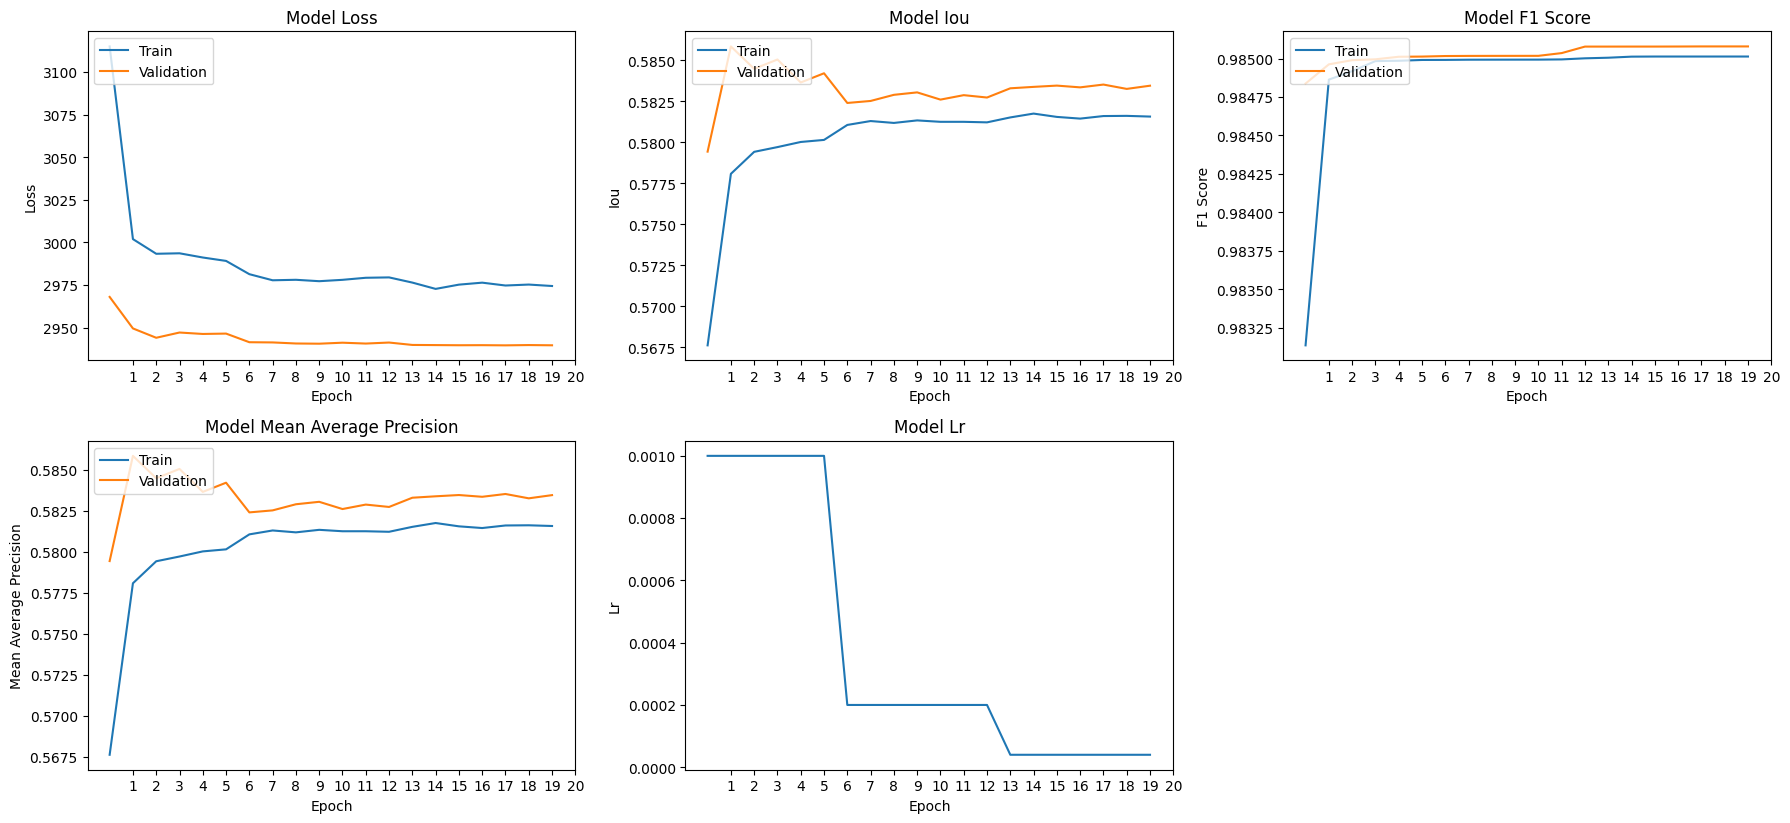

In [42]:
plot_metrics(history)

In [43]:
# Save the entire model
custom_cnn_model1.save(SAVE_PATH + 'custom_cnn_model1.keras')

In [44]:
# Load the model from a file
# custom_cnn_model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras')
gc.collect()

86821

## Custom CNN 2

In [45]:
class CustomCNNModel2:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                               f1_score,
                               mean_average_precision])
        
    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback, roc_auc_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val,
            'learning_rate': lr,
            'fpr' : fpr,
            'tpr' : tpr
        }
    
    def save(self, path):
        self.model.save(path)

    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model2 = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model2.compile_model()

custom_cnn_model2.model.summary()

Using device: /GPU:0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (No

In [46]:
# Train the model
history2 = custom_cnn_model2.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model2.evaluate(test_dataset)

Epoch 1/20
6355/6355 [==============================] - 457s 72ms/step - loss: 3112.6868 - iou: 0.5682 - precision_6: 0.9707 - recall_6: 0.9993 - f1_score: 0.9850 - mean_average_precision: 0.5682 - val_loss: 2953.2329 - val_iou: 0.5797 - val_precision_6: 0.9703 - val_recall_6: 1.0000 - val_f1_score: 0.9850 - val_mean_average_precision: 0.5797 - lr: 0.0010
Epoch 2/20
6355/6355 [==============================] - 443s 70ms/step - loss: 3022.8369 - iou: 0.5762 - precision_6: 0.9707 - recall_6: 1.0000 - f1_score: 0.9850 - mean_average_precision: 0.5762 - val_loss: 2961.1230 - val_iou: 0.5865 - val_precision_6: 0.9703 - val_recall_6: 1.0000 - val_f1_score: 0.9850 - val_mean_average_precision: 0.5865 - lr: 0.0010
Epoch 3/20
6355/6355 [==============================] - 443s 70ms/step - loss: 3008.0850 - iou: 0.5782 - precision_6: 0.9707 - recall_6: 1.0000 - f1_score: 0.9850 - mean_average_precision: 0.5782 - val_loss: 2964.4309 - val_iou: 0.5844 - val_precision_6: 0.9703 - val_recall_6: 1.0000

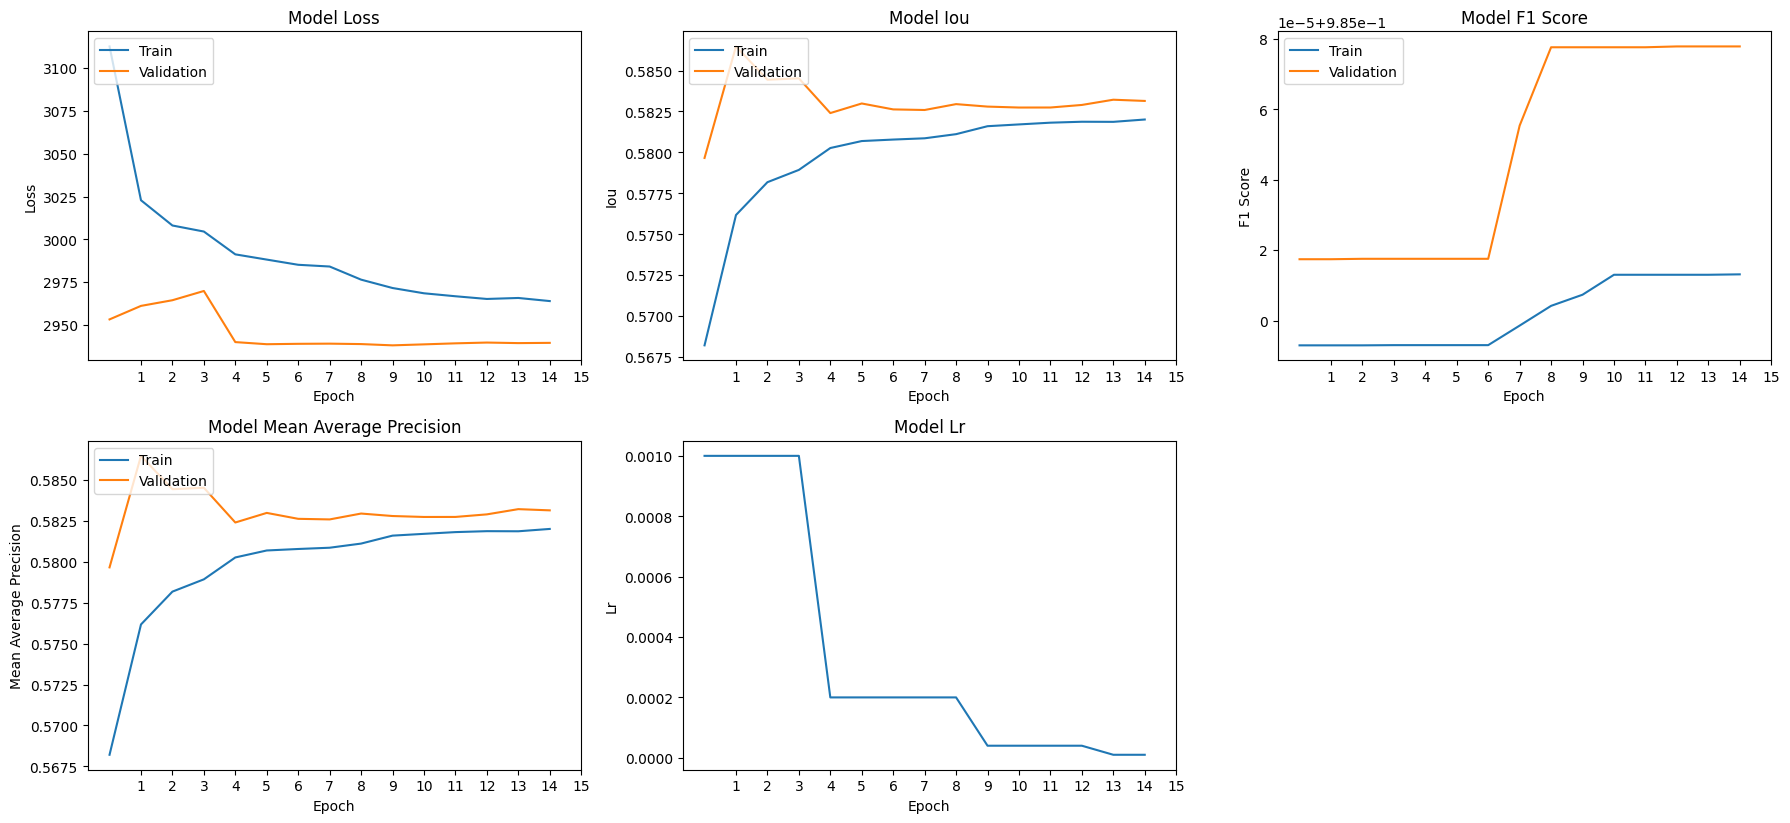

In [47]:
plot_metrics(history2)

In [48]:
# Save the entire model
custom_cnn_model2.save(SAVE_PATH + 'custom_cnn_model2.keras')

In [49]:
# Load the model from a file
# custom_cnn_model2 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras')
gc.collect()

21627

## Custom CNN 3

In [50]:
class CustomCNNModel3:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fifth Convolutional Block
            model.add(Conv2D(512, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
                self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                               f1_score,
                               mean_average_precision])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        roc_auc_callback = RocAucCallback(validation_data=val_dataset)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  roc_auc_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val,
            'learning_rate': lr,
            'fpr' : fpr,
            'tpr' : tpr
        }
    
    def save(self, path):
        self.model.save(path)
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model3 = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model3.compile_model()

custom_cnn_model3.model.summary()

Using device: /GPU:0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                 

In [51]:
# Train the model
history3 = custom_cnn_model3.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model3.evaluate(test_dataset)

Epoch 1/20
6355/6355 [==============================] - 715s 112ms/step - loss: 3045.2068 - iou: 0.5750 - precision_7: 0.9707 - recall_7: 0.9998 - f1_score: 0.9850 - mean_average_precision: 0.5750 - val_loss: 2984.3606 - val_iou: 0.5893 - val_precision_7: 0.9703 - val_recall_7: 1.0000 - val_f1_score: 0.9851 - val_mean_average_precision: 0.5893 - lr: 0.0010
Epoch 2/20
6355/6355 [==============================] - 718s 113ms/step - loss: 2998.0315 - iou: 0.5793 - precision_7: 0.9707 - recall_7: 1.0000 - f1_score: 0.9850 - mean_average_precision: 0.5793 - val_loss: 2963.6184 - val_iou: 0.5866 - val_precision_7: 0.9703 - val_recall_7: 1.0000 - val_f1_score: 0.9851 - val_mean_average_precision: 0.5866 - lr: 0.0010
Epoch 3/20
6355/6355 [==============================] - 712s 112ms/step - loss: 2978.3198 - iou: 0.5809 - precision_7: 0.9707 - recall_7: 1.0000 - f1_score: 0.9850 - mean_average_precision: 0.5809 - val_loss: 2982.5356 - val_iou: 0.5892 - val_precision_7: 0.9703 - val_recall_7: 1.0

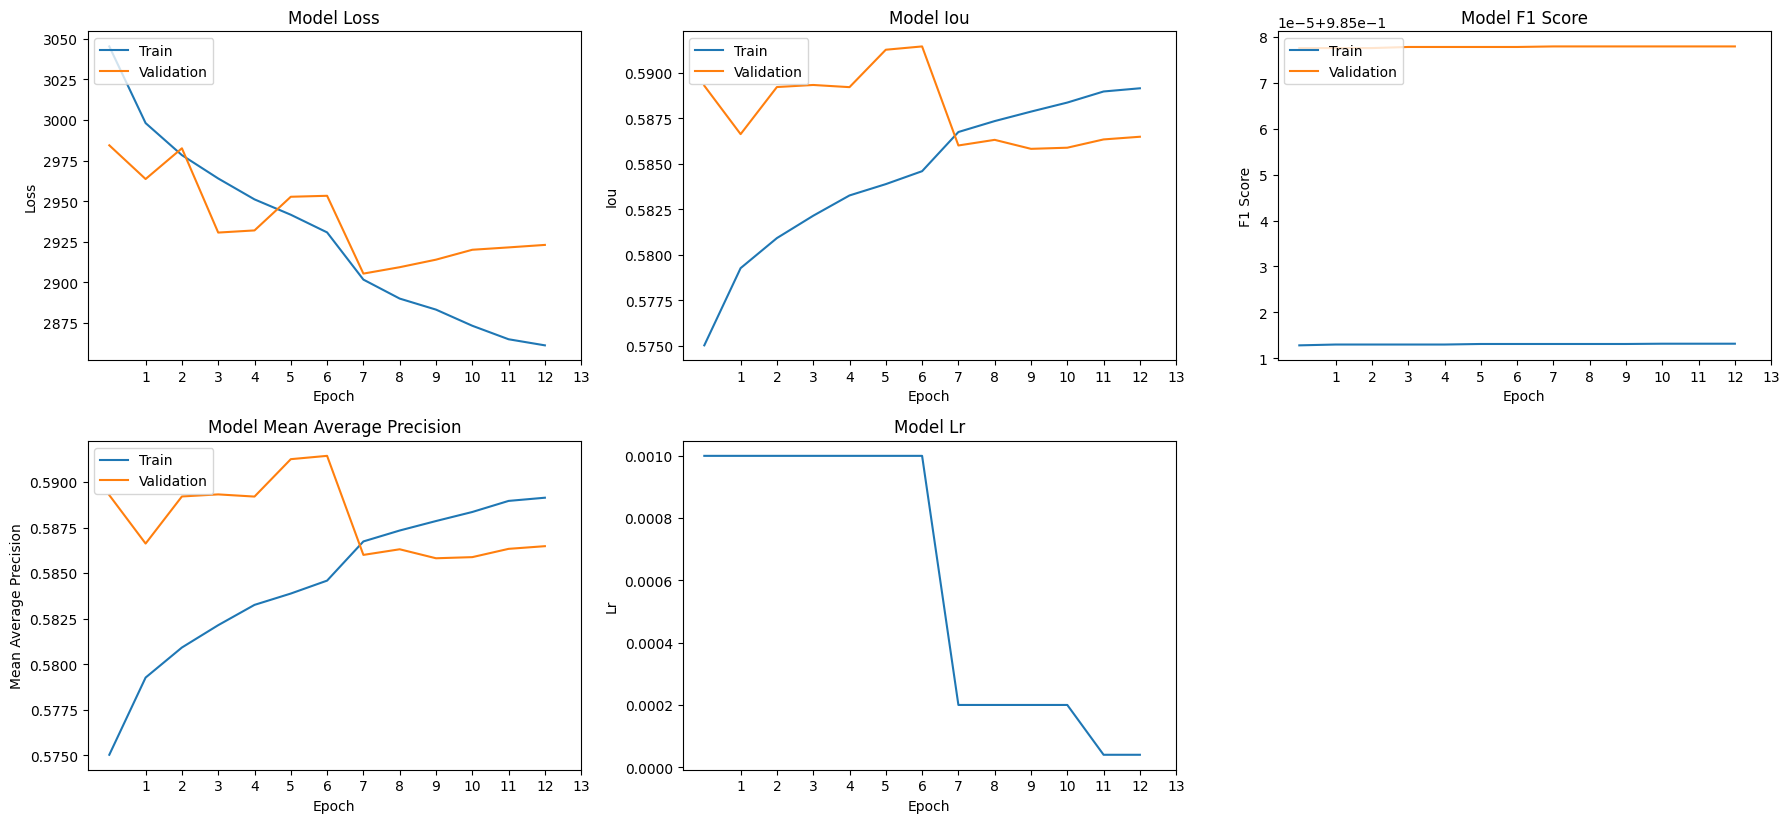

In [52]:
plot_metrics(history3)

In [53]:
# Save the entire model
custom_cnn_model3.save(SAVE_PATH + 'custom_cnn_model3.keras')

In [54]:
# Load the model from a file
# custom_cnn_model3 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model3.keras')
gc.collect()

20728

# Saving History

In [68]:
import pickle

with open('training_history_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

with open('training_history_2.pkl', 'wb') as file:
    pickle.dump(history2.history, file)
    
with open('training_history_3.pkl', 'wb') as file:
    pickle.dump(history3.history, file)

Using device: /GPU:0


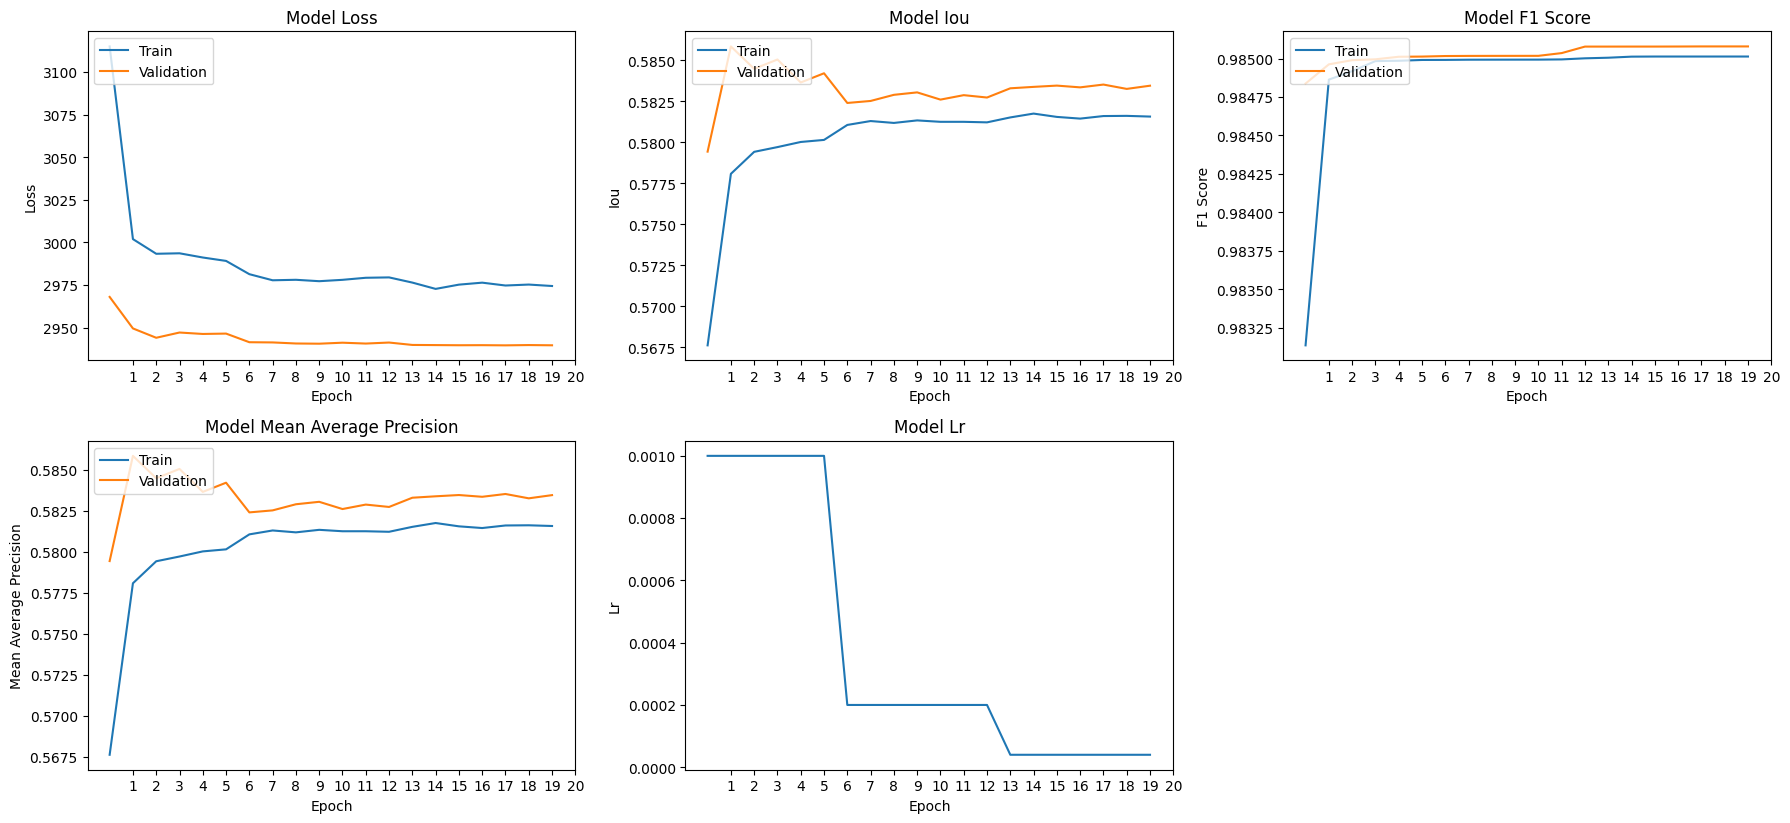

In [74]:
with open('training_history_1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


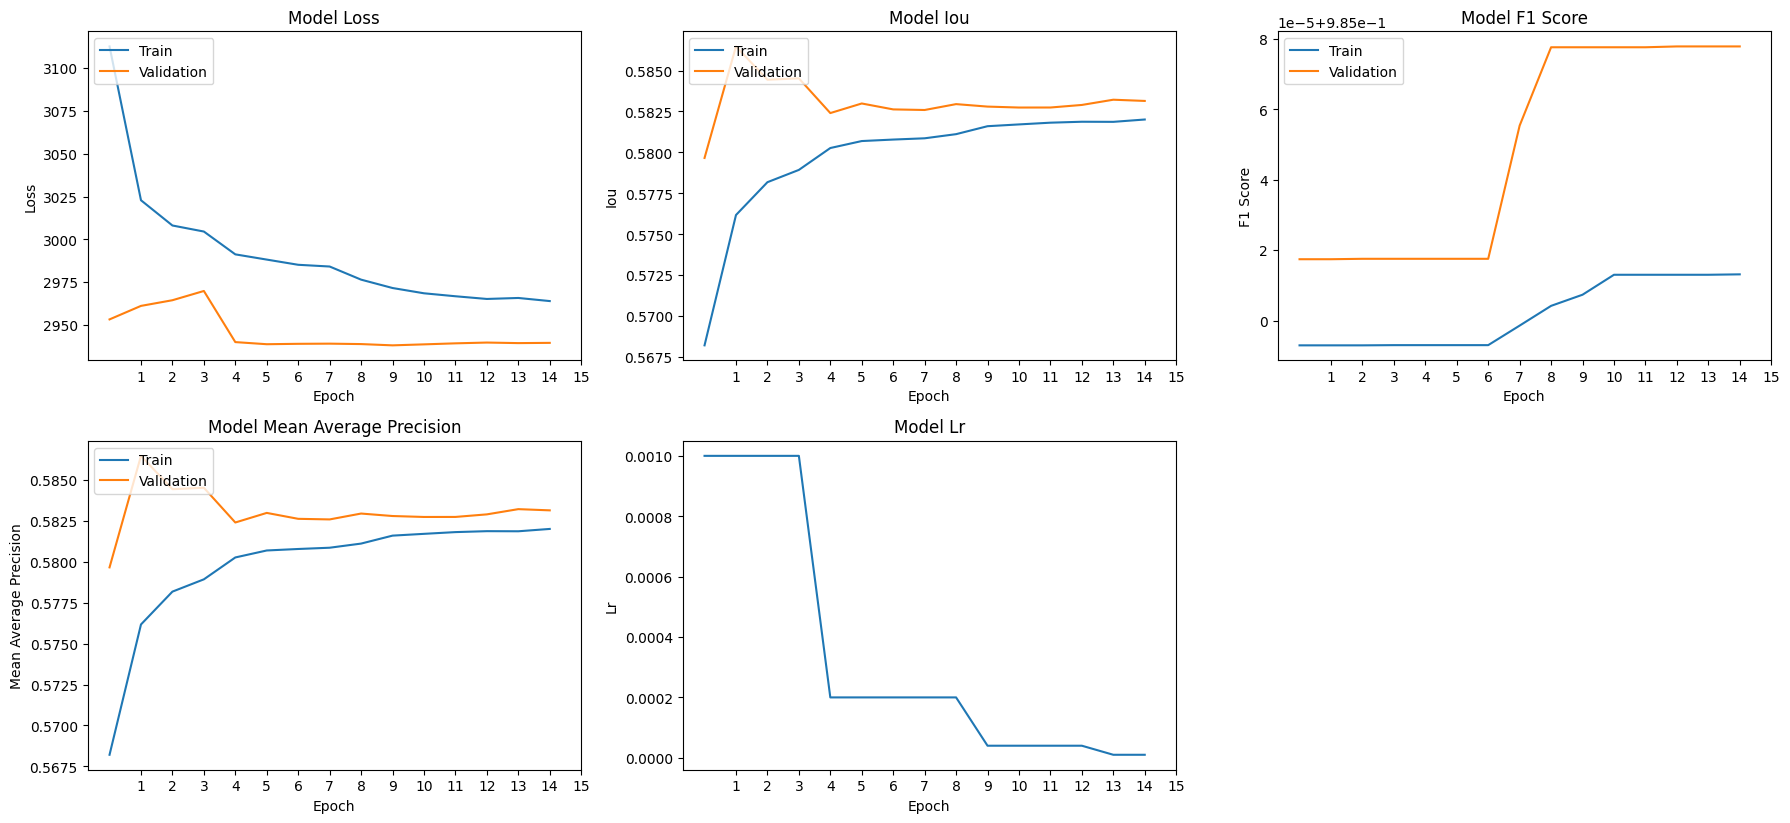

In [77]:
with open('training_history_2.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

Using device: /GPU:0


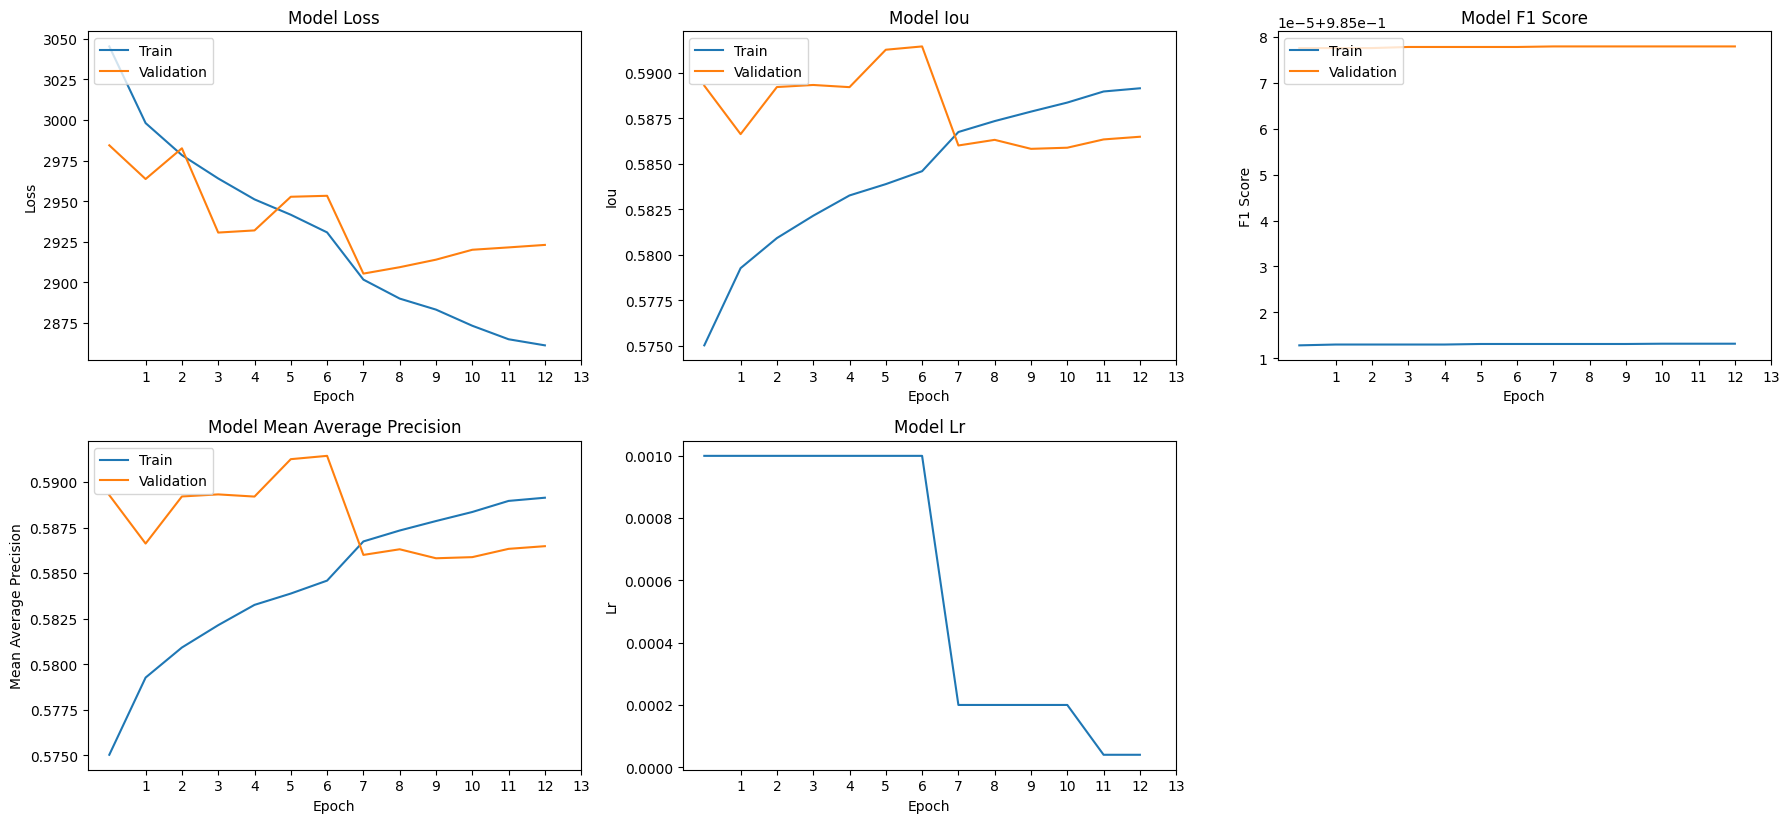

In [78]:
with open('training_history_3.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(train_dataset, val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

# Hyperparameter tuning for Custom CNN 1

In [ ]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(hp.Int('conv_4_filters', values=[64, 128, 256]), 
                         (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', values=[128, 256, 512]), 
                         (3, 3), activation='relu')),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', values=[256, 512, 1024]), 
                        activation='relu'), kernel_regularizer=l2(0.001)),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(4, activation=hp.Choice('dense_activation', values=['linear', 'sigmoid'])))  # Output layer with 4 units for bounding box coordinates (whxy)

        # Compile the model
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                        loss='mse',
                        metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                                f1_score,
                                mean_average_precision])
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        lr = self.model.optimizer.learning_rate.numpy()
        
        # Predict probabilities for the validation dataset
        y_true = []
        y_pred = []
        for x, y in val_dataset:
            y_true.extend(y.numpy())
            y_pred.extend(self.model.predict(x).ravel())
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val,
            'learning_rate': lr,
            'fpr' : fpr,
            'tpr' : tpr
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model1',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_optimizer = best_hyperparameters.get('optimizer')
print(f"Best optimizer: {best_optimizer}")



In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract the best learning rate if it was tuned
best_learning_rate = best_hyperparameters.values.get('learning_rate', 0.001)  # Default to 0.001 if not tuned

# Print the best learning rate to verify
print(f"Best learning rate: {best_learning_rate}")
print(best_hyperparameters.values)

# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                                   f1_score,
                                   mean_average_precision])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'bestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  roc_auc_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IOU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

In [ ]:
plot_metrics(history_best)

In [ ]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model1.keras')

# Hyperparameter tuning for Custom CNN 3

In [56]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(64, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(128, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=1024, step=256), 
                         (3, 3), activation=hp.Choice('conv_4_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fifth Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=512, max_value=1024, step=512), 
                         (3, 3), activation=hp.Choice('conv_5_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), 
                        activation=hp.Choice('dense_activation', values=['relu', 'sigmoid']), kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(4, activation=hp.Choice('dense_activation', values=['linear', 'sigmoid'])))  # Output layer with 4 units for bounding box coordinates (whxy)

        # Compile the model
        optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        if optimizer == 'adam':
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                          loss='mse',
                          metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                                   f1_score,
                                   mean_average_precision])
        elif optimizer == 'sgd':
            model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
                          loss='mse',
                          metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                                   f1_score,
                                   mean_average_precision])
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, iou_val, precision_val, recall_val, f1_score_val, map_val = results
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, IoU: {iou_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1-Score: {f1_score_val:.4f}, mAP: {map_val:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'iou': iou_val,
            'precision': precision_val,
            'recall': recall_val,
            'f1_score': f1_score_val,
            'mean_average_precision': map_val,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model2',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=32)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=32)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model2 = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model2.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_optimizer = best_hyperparameters.get('optimizer')
print(f"Best optimizer: {best_optimizer}")


Trial 26 Complete [02h 58m 01s]
val_loss: 9906.8388671875

Best val_loss So Far: 2905.125732421875
Total elapsed time: 1d 17h 07m 04s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
768               |512               |conv_4_filters
relu              |sigmoid           |conv_4_activation
512               |512               |conv_5_filters
sigmoid           |relu              |conv_5_activation
1024              |256               |dense_units
relu              |relu              |dense_activation
0.2               |0.3               |dropout_rate
adam              |sgd               |optimizer
0.001753          |0.00021           |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/20
6355/6355 [==============================] - 961s 151ms/step - loss: 3003.1411 - iou: 0.

KeyboardInterrupt: 

In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract the best learning rate if it was tuned
best_learning_rate = best_hyperparameters.values.get('learning_rate', 0.001)  # Default to 0.001 if not tuned

# Print the best learning rate to verify
print(f"Best learning rate: {best_learning_rate}")
print(best_hyperparameters.values)

# Build the model using the best hyperparameters
best_model2 = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)

# Compile the model with the optimizer
best_model2.compile(optimizer=optimizer,
                          loss='mse',
                          metrics=[iou, tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                                   f1_score,
                                   mean_average_precision])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'bestCustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
roc_auc_callback = RocAucCallback(validation_data=val_dataset)

# Train the model on the full dataset
history_best2 = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback,  roc_auc_callback])

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, IOU: {result[1]}, Testing precision: {result[2]}, Testing Recall: {result[3]}, Testing f1 score: {result[4]}, Testing mAP: {result[5]}')

Best learning rate: 0.0029994788478703836
{'conv_3_filters': 256, 'conv_3_activation': 'sigmoid', 'conv_4_filters': 256, 'conv_4_activation': 'sigmoid', 'conv_5_filters': 512, 'conv_5_activation': 'relu', 'dense_units': 512, 'dense_activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.0029994788478703836, 'tuner/epochs': 7, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - f1_score: 0.8532 - iou: 0.0252 - loss: 1330.3479 - mean_average_precision: 0.0252 - precision_2: 1.0000 - recall_2: 0.4348 - val_f1_score: 0.8531 - val_iou: 0.1122 - val_loss: 7301.5957 - val_mean_average_precision: 0.1122 - val_precision_2: 0.6667 - val_recall_2: 0.6667
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - f1_score: 0.8530 - iou: 0.1442 - loss: 1042.1229 - mean_average_precision: 0.1442 - precision_2: 0.9444 - recall_2: 0.7391 - val_f1_score: 0.8528 - val_iou: 0.2630 - val_loss: 4818.9575 - val_mean_average_p

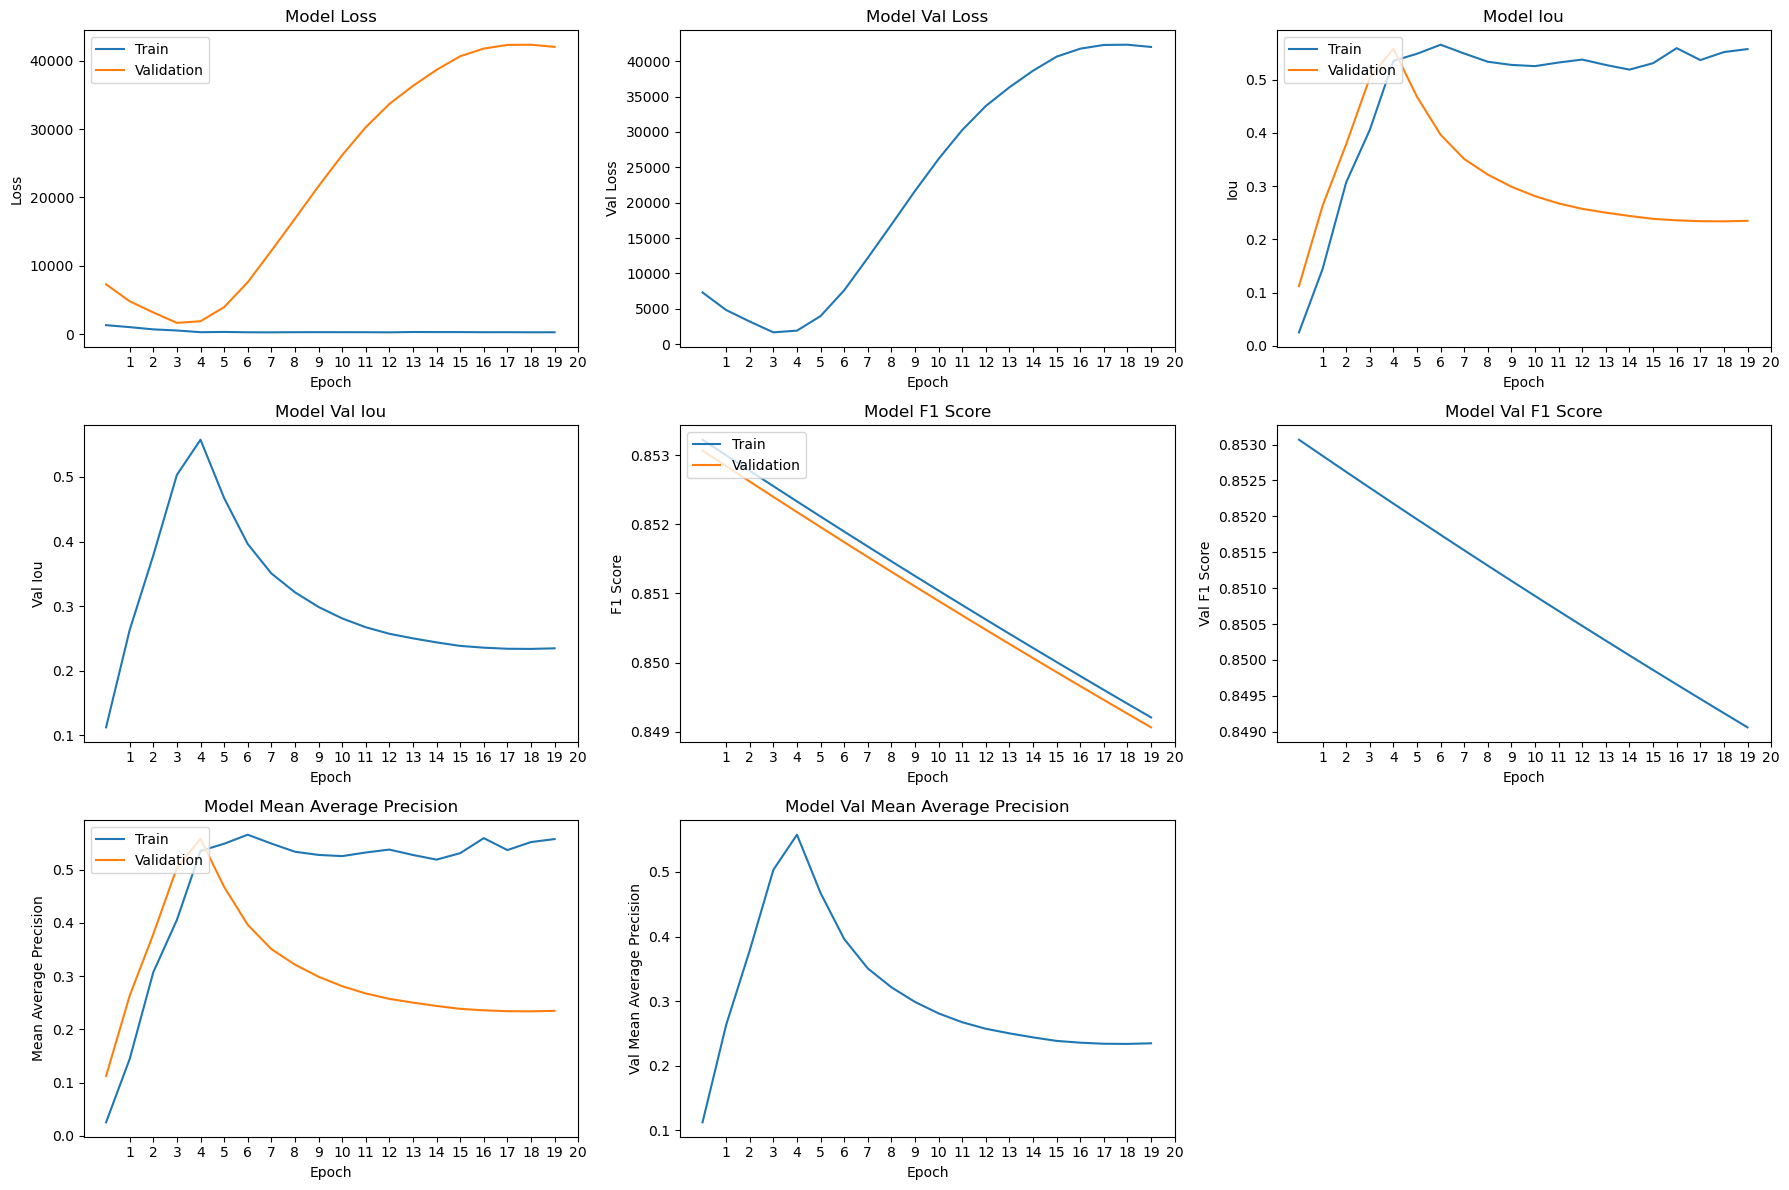

In [ ]:
plot_metrics(history_best2)

In [ ]:
best_model2.save(SAVE_PATH + 'best_custom_cnn_model3.keras')

# OS

In [ ]:
import os

# Path to your MP3 file
# mp3_file = r"C:\Users\WenShen\Documents\GitHub\That's Why I Like You.mp3"

# Use the os module to call Windows Media Player
# os.system(f'start wmplayer "{mp3_file}"')

sh: start: command not found


32512

- hyperparameter tuning and models path zip and send to me for compile